# MNIST Dataset Example <a name="MNIST-Dataset-Example-mnist"></a>
## Set Up Environment <a name="Set-Up-Environment-mnist"></a>
**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency

## Downloading the Dataset <a name="Download-the-Dataset-mnist"></a>

The MNIST dataset consists of 70,000 28x28 grayscale images of handwritten numbers.
Each image is stored as a column vector, resulting in a (70000,784) shape for the entire dataset.

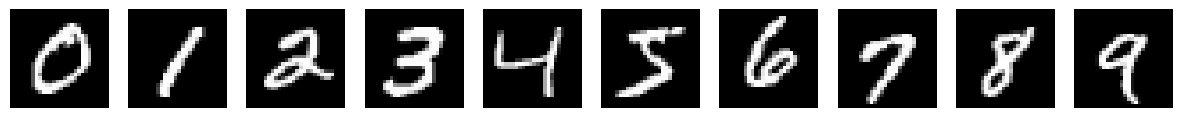

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
import os

cwd = os.getcwd()
data_dir = cwd + '/data/scikit-learn-example'

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, data_home=data_dir)
X = X/X.max()

# Find examples of each class
ref_inds = []
for i in range(10):
    ref_inds.append(np.where(np.int64(y) == i)[0][0])
    
ref_imgs = X[ref_inds]

# Plot examples
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(ref_imgs[i].reshape(28, 28), 'gray')
    plt.axis('off')
    

# Logistic Regression Example <a name="Logistic-Regression-Example-mnist"></a>
## Fitting the Model <a name="Fitting-the-Model-logistic-mnist"></a>

We take the same `LogisticRegression` object used in the scikit-learn example and fit it to a subset of the dataset.
Here, an L2 penalty and a larger training set is used to yield slightly better results than those shown in the example.
The same visualization of the coefficients is shown with these new parameters.

Test score with L2 penalty: 0.8865
Example run in 3.149 s


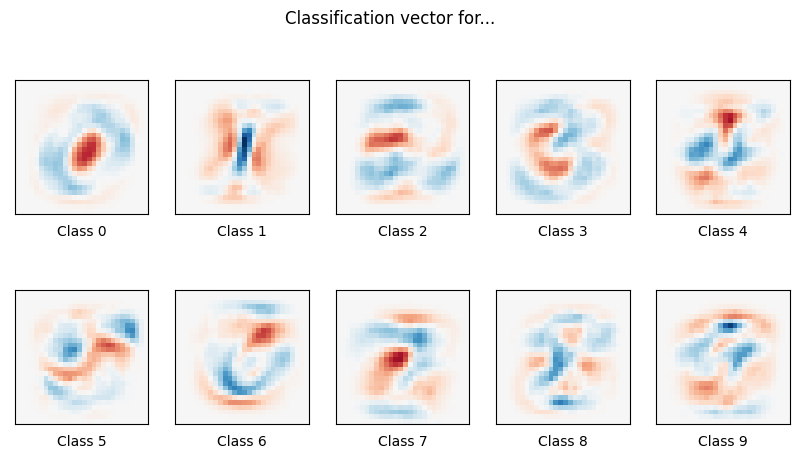

In [8]:
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import mlflow

# def test_mlflow():
t0 = time.time()

# Split data into test and train sets
train_samples = 20000

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000, random_state=0)

# Define model, lower C value gives higher regulation
clf = LogisticRegression(
    C=50. / train_samples, penalty='l2', solver='saga', tol=0.1, random_state=0
)

# Fit model
clf.fit(X_train, y_train)

# Score model
score = clf.score(X_test, y_test)
print("Test score with L2 penalty: %.4f" % score)

# Visualize coefficients
coef = clf.coef_.copy()
max_val = np.abs(coef).max()

fig = plt.figure(figsize=(10, 5))
for i in range(10):
    p = plt.subplot(2, 5, i + 1)
    p.imshow(coef[i].reshape(28, 28), cmap=plt.cm.RdBu,
            vmin=-max_val, vmax=max_val)
    p.set_xticks(())
    p.set_yticks(())
    p.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()

# Sample mlflow run under Default Experiment
mlflow.set_tracking_uri("http://localhost:5000")
with mlflow.start_run():
    mlflow.log_param('model', 'Logistic Regression')
    mlflow.log_metric('score', score)
    mlflow.log_figure(fig,"class_vector.png")


# MLP Example <a name="MLP-Example-mnist"></a>
## Fitting the Model <a name="Fitting-the-Model-mlp-mnist"></a>

Following the second [example](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py) from scikit-learn, we training an `MLPClassifier` on the MNIST dataset using the same hyperparameters.

To shorten training time, the MLP has only one hidden layer with 50 nodes, and is only trained for 10 iterations, meaning the model does not converge.

In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
import mlflow
from mlflow import MlflowClient
from pprint import pprint
import matplotlib.pyplot as plt
from pathlib import Path

def log_data(experiment_name):

    client = MlflowClient()
    
    experiment_id = client.create_experiment(experiment_name,
                                    artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
                                    tags={"version": "v1", "priority": "P1"})
    client.set_experiment_tag(experiment_id, "sklearn.framework", "MLP Classifier")
    experiment = client.get_experiment(experiment_id)
    
    print("Name: {}".format(experiment.name))
    print("Experiment_id: {}".format(experiment.experiment_id))
    print("Artifact Location: {}".format(experiment.artifact_location))
    print("Tags: {}".format(experiment.tags))
    print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
    
    with mlflow.start_run(experiment_id=experiment_id) as run:
        
        # Model parameters
        mlflow.log_params(params)
        
        # Numpy array saved under tags
        mlflow.set_tag("XTrain", X_train)
        
        # Training loss
        for epoch in x.loss_curve_:
            mlflow.log_metric('Train loss',epoch)
        
        # Final model checkpoint
        mlflow.sklearn.log_model(x, artifact_path="sklearn-model")
        
        # Numpy array saved under artifacts
        mlflow.log_artifact(pth + '.npy') 

# use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

pth = os.path.join('./mlruns','XTrain')
np.save(pth,X_train)

params = {"hidden_layer_sizes" : (50,), "max_iter" : 10, "alpha": 1e-4,
          "solver" :'sgd', "verbose": 10, "random_state": 1,
          "learning_rate_init" : .1}

mlp = MLPClassifier(**params)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")
    x = mlp.fit(X_train, y_train)

log_data("MLP Classifier")

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355
Name: MLP Classifier
Experiment_id: 769008555571228852
Artifact Location: file:///data/barry.ravichandran/XAITK/xaitk-cdao/examples/mlflow/mlruns
Tags: {'sklearn.framework': 'MLP Classifier', 'version': 'v1', 'priority': 'P1'}
Lifecycle_stage: active


/data/barry.ravichandran/envs/xaitk/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
